# Visualising the outbreak curves

Import things

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import os
import pylab as plt

import seaborn as sns
sns.set(style="darkgrid")

In [2]:
pwd

'/Users/swise/workspace/worldbank/Disease-Modelling-SSA/notebooks'

Identify the input files and read them in

In [3]:
namepart = "0.016_1_60_12345"#"0.06_100_12345"#_interrupted"#notravellers"
results_filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/java/WorldBankCovid19/results_" + namepart + ".txt"


Infections available too!

In [4]:
#infections_filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/java/WorldBankCovid19/infections" + namepart + ".txt"
#i_data = pd.read_csv(infections_filename, sep='\t')

In [5]:
r_data = pd.read_csv(results_filename, sep='\t')
r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]


You can aggregate these and write them out to a file for visualisation in QGIS, if you so choose

In [6]:
r_data

,time,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,Unnamed: 8,districtId
0,0,d_38,0,0,0,0,0,0,NaN,38
1,0,d_39,0,0,0,0,0,0,NaN,39
2,0,d_47,0,0,0,0,0,0,NaN,47
3,0,d_48,0,0,0,0,0,0,NaN,48
4,0,d_45,0,0,0,0,0,0,NaN,45
...,...,...,...,...,...,...,...,...,...,...
3595,59,d_55,0,0,0,0,0,0,NaN,55
3596,59,d_52,0,0,0,0,0,0,NaN,52
3597,59,d_53,0,0,0,0,0,0,NaN,53
3598,59,d_50,0,0,0,0,0,0,NaN,50


In [7]:
r_agg = r_data.groupby('districtId').agg({'metric_died_count': 'max', 'metric_new_hospitalized': 'sum', 
                                    'metric_new_critical': 'sum', 'metric_new_cases_asympt': 'sum',
                                    'metric_new_cases_sympt': 'sum'})
#r_agg = r_agg[r_agg['metric_new_cases_sympt'] > 5].sort_values(by='metric_new_cases_sympt', ascending=False)
#r_agg.to_csv("totalSympt.csv", sep=',')

In [8]:
r_agg.head()

,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt
districtId,,,,,
1,0,0,0,1,0
2,0,1,0,6,6
3,0,0,0,0,0
4,0,0,0,0,0
5,0,0,0,0,0


Lazier aggregation also available

In [9]:
sum(r_data['metric_new_cases_sympt'])

14

## Graphing the outbreak curves

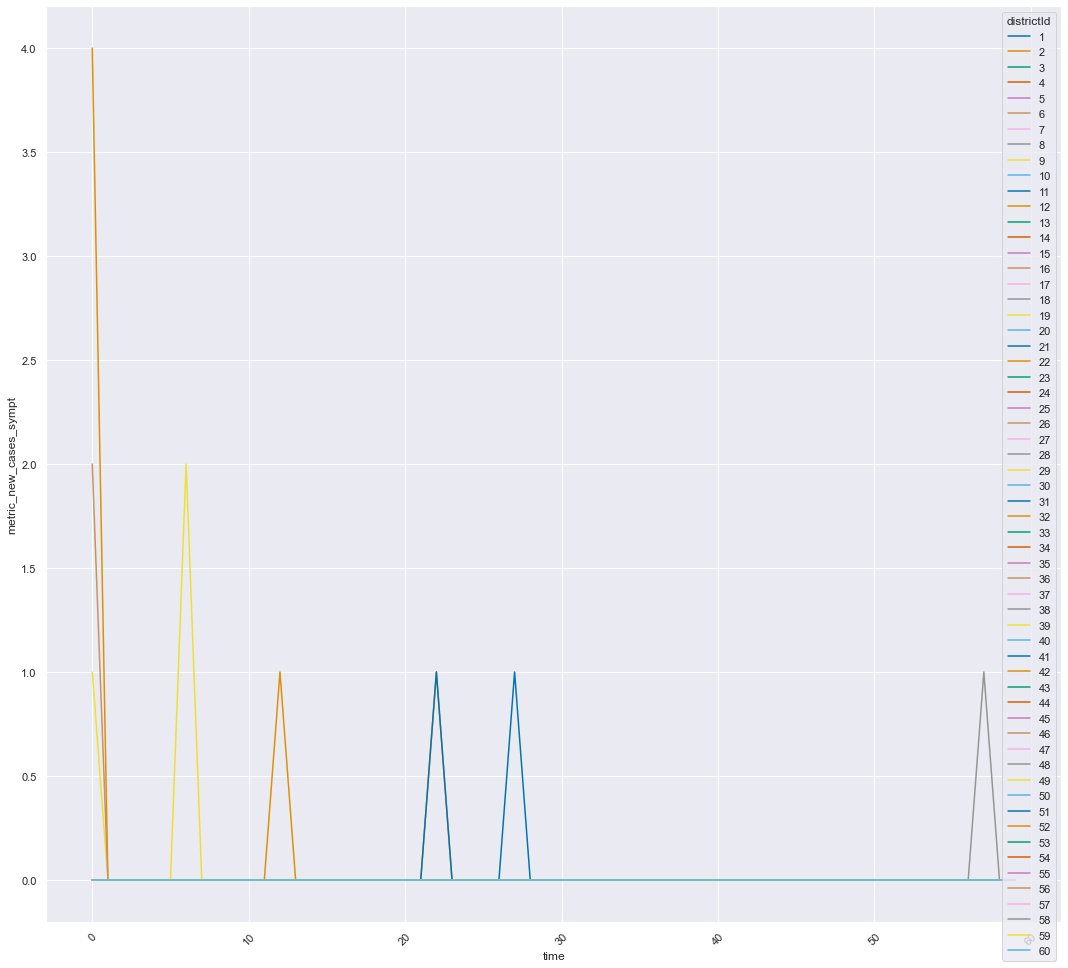

In [10]:
#sns.scatterplot(
fig, ax = plt.subplots (figsize = (15,15))
sns.lineplot(
             x="time", 
             #y="metric_new_deaths",
             #y="metric_new_hospitalized",
             y="metric_new_cases_sympt", 
             palette="colorblind", 
             hue="districtId",
             ax = ax,
             data=r_data#,
#            legend=False
            )#.legend(bbox_to_anchor= (1.03, 1) )

#ax.set_title('New Deaths', fontsize=20)
#ax.set_ylabel('Number of deaths')
#ax.legend(fontsize=10, title_fontsize=30, loc='upper left')
#ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#ax.patch.set_alpha(0)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)
plt.xticks(rotation=45)
plt.tight_layout()

# Mapping results

In [11]:
import geopandas
import math

In [12]:
#path_to_data = geopandas.datasets.get_path()
rawLocs = geopandas.read_file("/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/raw/shapefiles/new_districts/ZWE_adm2.shp")
trunkRoads = geopandas.read_file("/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/raw/shapefiles/osm_trunk_roads.shp")
rawLocs

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,256,ZWE,Zimbabwe,1,Bulawayo,1,Bulawayo,District,District,None,None,"POLYGON ((28.61305 -20.23587, 28.60440 -20.225..."
1,256,ZWE,Zimbabwe,2,Harare,2,Harare,District,District,None,Salisbury|Harare Urban,"POLYGON ((31.08852 -17.66625, 31.11038 -17.667..."
2,256,ZWE,Zimbabwe,3,Manicaland,3,Buhera,District,District,None,None,"POLYGON ((32.39763 -19.76925, 32.39830 -19.780..."
3,256,ZWE,Zimbabwe,3,Manicaland,4,Chimanimani,District,District,None,None,"POLYGON ((33.01395 -20.01098, 33.01094 -20.018..."
4,256,ZWE,Zimbabwe,3,Manicaland,5,Chipinge,District,District,None,None,"POLYGON ((32.42310 -21.06366, 32.40906 -21.078..."
5,256,ZWE,Zimbabwe,3,Manicaland,6,Makoni,District,District,None,None,"POLYGON ((31.98373 -19.11975, 31.98071 -19.108..."
6,256,ZWE,Zimbabwe,3,Manicaland,7,Mutare,District,District,None,Umtali,"POLYGON ((32.77855 -19.37489, 32.77308 -19.375..."
7,256,ZWE,Zimbabwe,3,Manicaland,8,Mutasa,District,District,None,None,"POLYGON ((32.44506 -18.39830, 32.45688 -18.392..."
8,256,ZWE,Zimbabwe,3,Manicaland,9,Nyanga,District,District,None,None,"POLYGON ((32.99868 -18.20377, 32.99176 -18.203..."
9,256,ZWE,Zimbabwe,4,Mashonaland Central,10,Bindura,District,District,None,None,"POLYGON ((31.40236 -16.83971, 31.40105 -16.853..."


Join this with the previous data!

In [13]:
dataLocs = rawLocs.merge(r_agg, how="left", left_on=['ID_2'], right_on=['districtId'])


In [14]:
dataLocs

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt
0,256,ZWE,Zimbabwe,1,Bulawayo,1,Bulawayo,District,District,None,None,"POLYGON ((28.61305 -20.23587, 28.60440 -20.225...",0,0,0,1,0
1,256,ZWE,Zimbabwe,2,Harare,2,Harare,District,District,None,Salisbury|Harare Urban,"POLYGON ((31.08852 -17.66625, 31.11038 -17.667...",0,1,0,6,6
2,256,ZWE,Zimbabwe,3,Manicaland,3,Buhera,District,District,None,None,"POLYGON ((32.39763 -19.76925, 32.39830 -19.780...",0,0,0,0,0
3,256,ZWE,Zimbabwe,3,Manicaland,4,Chimanimani,District,District,None,None,"POLYGON ((33.01395 -20.01098, 33.01094 -20.018...",0,0,0,0,0
4,256,ZWE,Zimbabwe,3,Manicaland,5,Chipinge,District,District,None,None,"POLYGON ((32.42310 -21.06366, 32.40906 -21.078...",0,0,0,0,0
5,256,ZWE,Zimbabwe,3,Manicaland,6,Makoni,District,District,None,None,"POLYGON ((31.98373 -19.11975, 31.98071 -19.108...",0,0,0,0,0
6,256,ZWE,Zimbabwe,3,Manicaland,7,Mutare,District,District,None,Umtali,"POLYGON ((32.77855 -19.37489, 32.77308 -19.375...",0,0,0,0,0
7,256,ZWE,Zimbabwe,3,Manicaland,8,Mutasa,District,District,None,None,"POLYGON ((32.44506 -18.39830, 32.45688 -18.392...",0,0,0,0,0
8,256,ZWE,Zimbabwe,3,Manicaland,9,Nyanga,District,District,None,None,"POLYGON ((32.99868 -18.20377, 32.99176 -18.203...",0,0,0,0,0
9,256,ZWE,Zimbabwe,4,Mashonaland Central,10,Bindura,District,District,None,None,"POLYGON ((31.40236 -16.83971, 31.40105 -16.853...",0,0,0,0,0


In [15]:
dataLocs["log_died"] = [max(0, math.log10(max(y, .00000001))) for y in dataLocs["metric_died_count"]]
dataLocs["log_sympt"] = [max(0, math.log10(max(y, .00000001))) for y in dataLocs["metric_new_cases_sympt"]]


<AxesSubplot:>

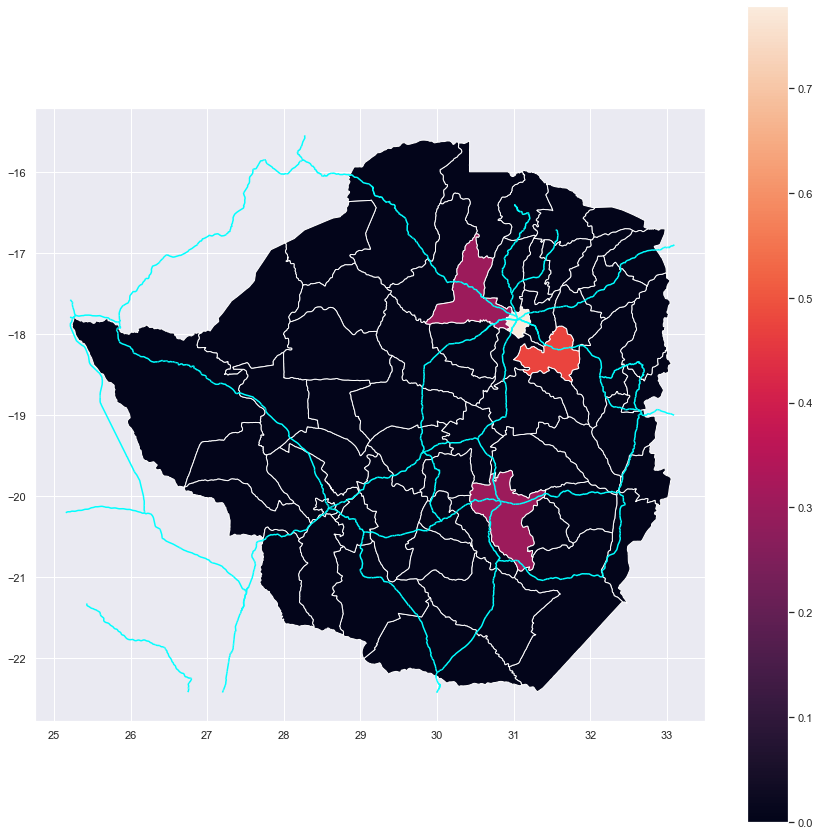

In [16]:
fig, ax = plt.subplots (figsize = (15,15))
#dataLocs.plot("metric_new_cases_sympt", ax = ax, legend=True)
dataLocs.plot("log_sympt", ax = ax, legend=True)

trunkRoads.plot(ax=ax, color="cyan")
